In [4]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.probability import ConditionalFreqDist
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
plt.style.use("dark_background")

df = pd.read_csv("_data/3_arXiv_Dataset/arxiv_preprocessed.csv")
df.head()

,abstract,update_date,processed_abstract,merged_category
0,A fully differential calculation in perturba...,2008-11-26,fully differential calculation perturbative qu...,High Energy Physics
1,"We describe a new algorithm, the $(k,\ell)$-...",2008-12-13,describe new algorithm game color use obtain c...,Mathematics
2,The evolution of Earth-Moon system is descri...,2008-01-13,evolution system described dark matter field f...,Physics
3,We show that a determinant of Stirling cycle...,2007-05-23,show determinant stirling cycle number count u...,Mathematics
4,In this paper we show how to compute the $\L...,2013-10-15,paper show compute norm 0 using dyadic grid re...,Mathematics


In [5]:
text_column = 'processed_abstract'
category_column = 'merged_category'

df = df.sample(400000, random_state=42)
df = df.dropna()

X = df[text_column]
y = df[category_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
feature_names = tfidf_vectorizer.get_feature_names_out()

df.describe()

,abstract,update_date,processed_abstract,merged_category
count,399997,399997,399997,399997
unique,399927,4984,399902,11
top,This paper has been withdrawn.\n,2007-05-23,paper ha withdrawn author,Computer Science
freq,11,19196,27,88855


# Decision Tree

In [6]:
def create_rule_based_classifier(X_train, y_train, feature_names, max_depth=5):
    rules = {}
    trees = {}
    classes = np.unique(y_train)

    for category in classes:
        # Convert to binary classification: this category vs all others
        y_binary = (y_train == category).astype(int)

        # Create a decision tree with controlled depth
        tree = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
        tree.fit(X_train, y_binary)

        # Extract rules as text
        tree_rules = export_text(tree, feature_names=feature_names)

        # Store both the rules and the trained tree
        rules[category] = tree_rules
        trees[category] = tree

    return rules, trees

# Use the trained trees for prediction
def predict_with_trees(X_test, trees, categories):
    predictions = []

    for i in range(X_test.shape[0]):
        sample = X_test[i:i+1]  # Keep sparse format intact

        # Get prediction probability from each category's tree
        category_scores = {}
        for cat in categories:
            # Get probability of positive class (index 1)
            proba = trees[cat].predict_proba(sample)[0][1]
            category_scores[cat] = proba

        # Select category with highest probability
        predicted_category = max(category_scores.items(), key=lambda x: x[1])[0]
        predictions.append(predicted_category)

    return predictions

categories = np.unique(y_train)
tree_rules, trained_trees = create_rule_based_classifier(X_train_tfidf, y_train, feature_names)
y_pred_method1_tfidf = predict_with_trees(X_test_tfidf, trained_trees, categories)
accuracy_method1_tfidf = accuracy_score(y_test, y_pred_method1_tfidf)
print(f"\nMethod 1 (TF-IDF) Accuracy: {accuracy_method1_tfidf:.4f}")
print(classification_report(y_test, y_pred_method1_tfidf))


Method 1 (TF-IDF) Accuracy: 0.6114
                                   precision    recall  f1-score   support

         Astrophysics & Cosmology       0.90      0.62      0.73     11342
                 Computer Science       0.72      0.69      0.70     17771
              Economics & Finance       0.48      0.37      0.42       620
            Engineering & Systems       0.31      0.07      0.12      1740
              High Energy Physics       0.80      0.46      0.59      8593
                    Life Sciences       0.43      0.29      0.35       923
                      Mathematics       0.49      0.83      0.62     15742
                  Nuclear Physics       0.53      0.48      0.50      1340
                          Physics       0.55      0.55      0.55     15910
                  Quantum Physics       0.55      0.65      0.60      3462
Statistics & Mathematical Physics       0.48      0.15      0.23      2557

                         accuracy                           0.

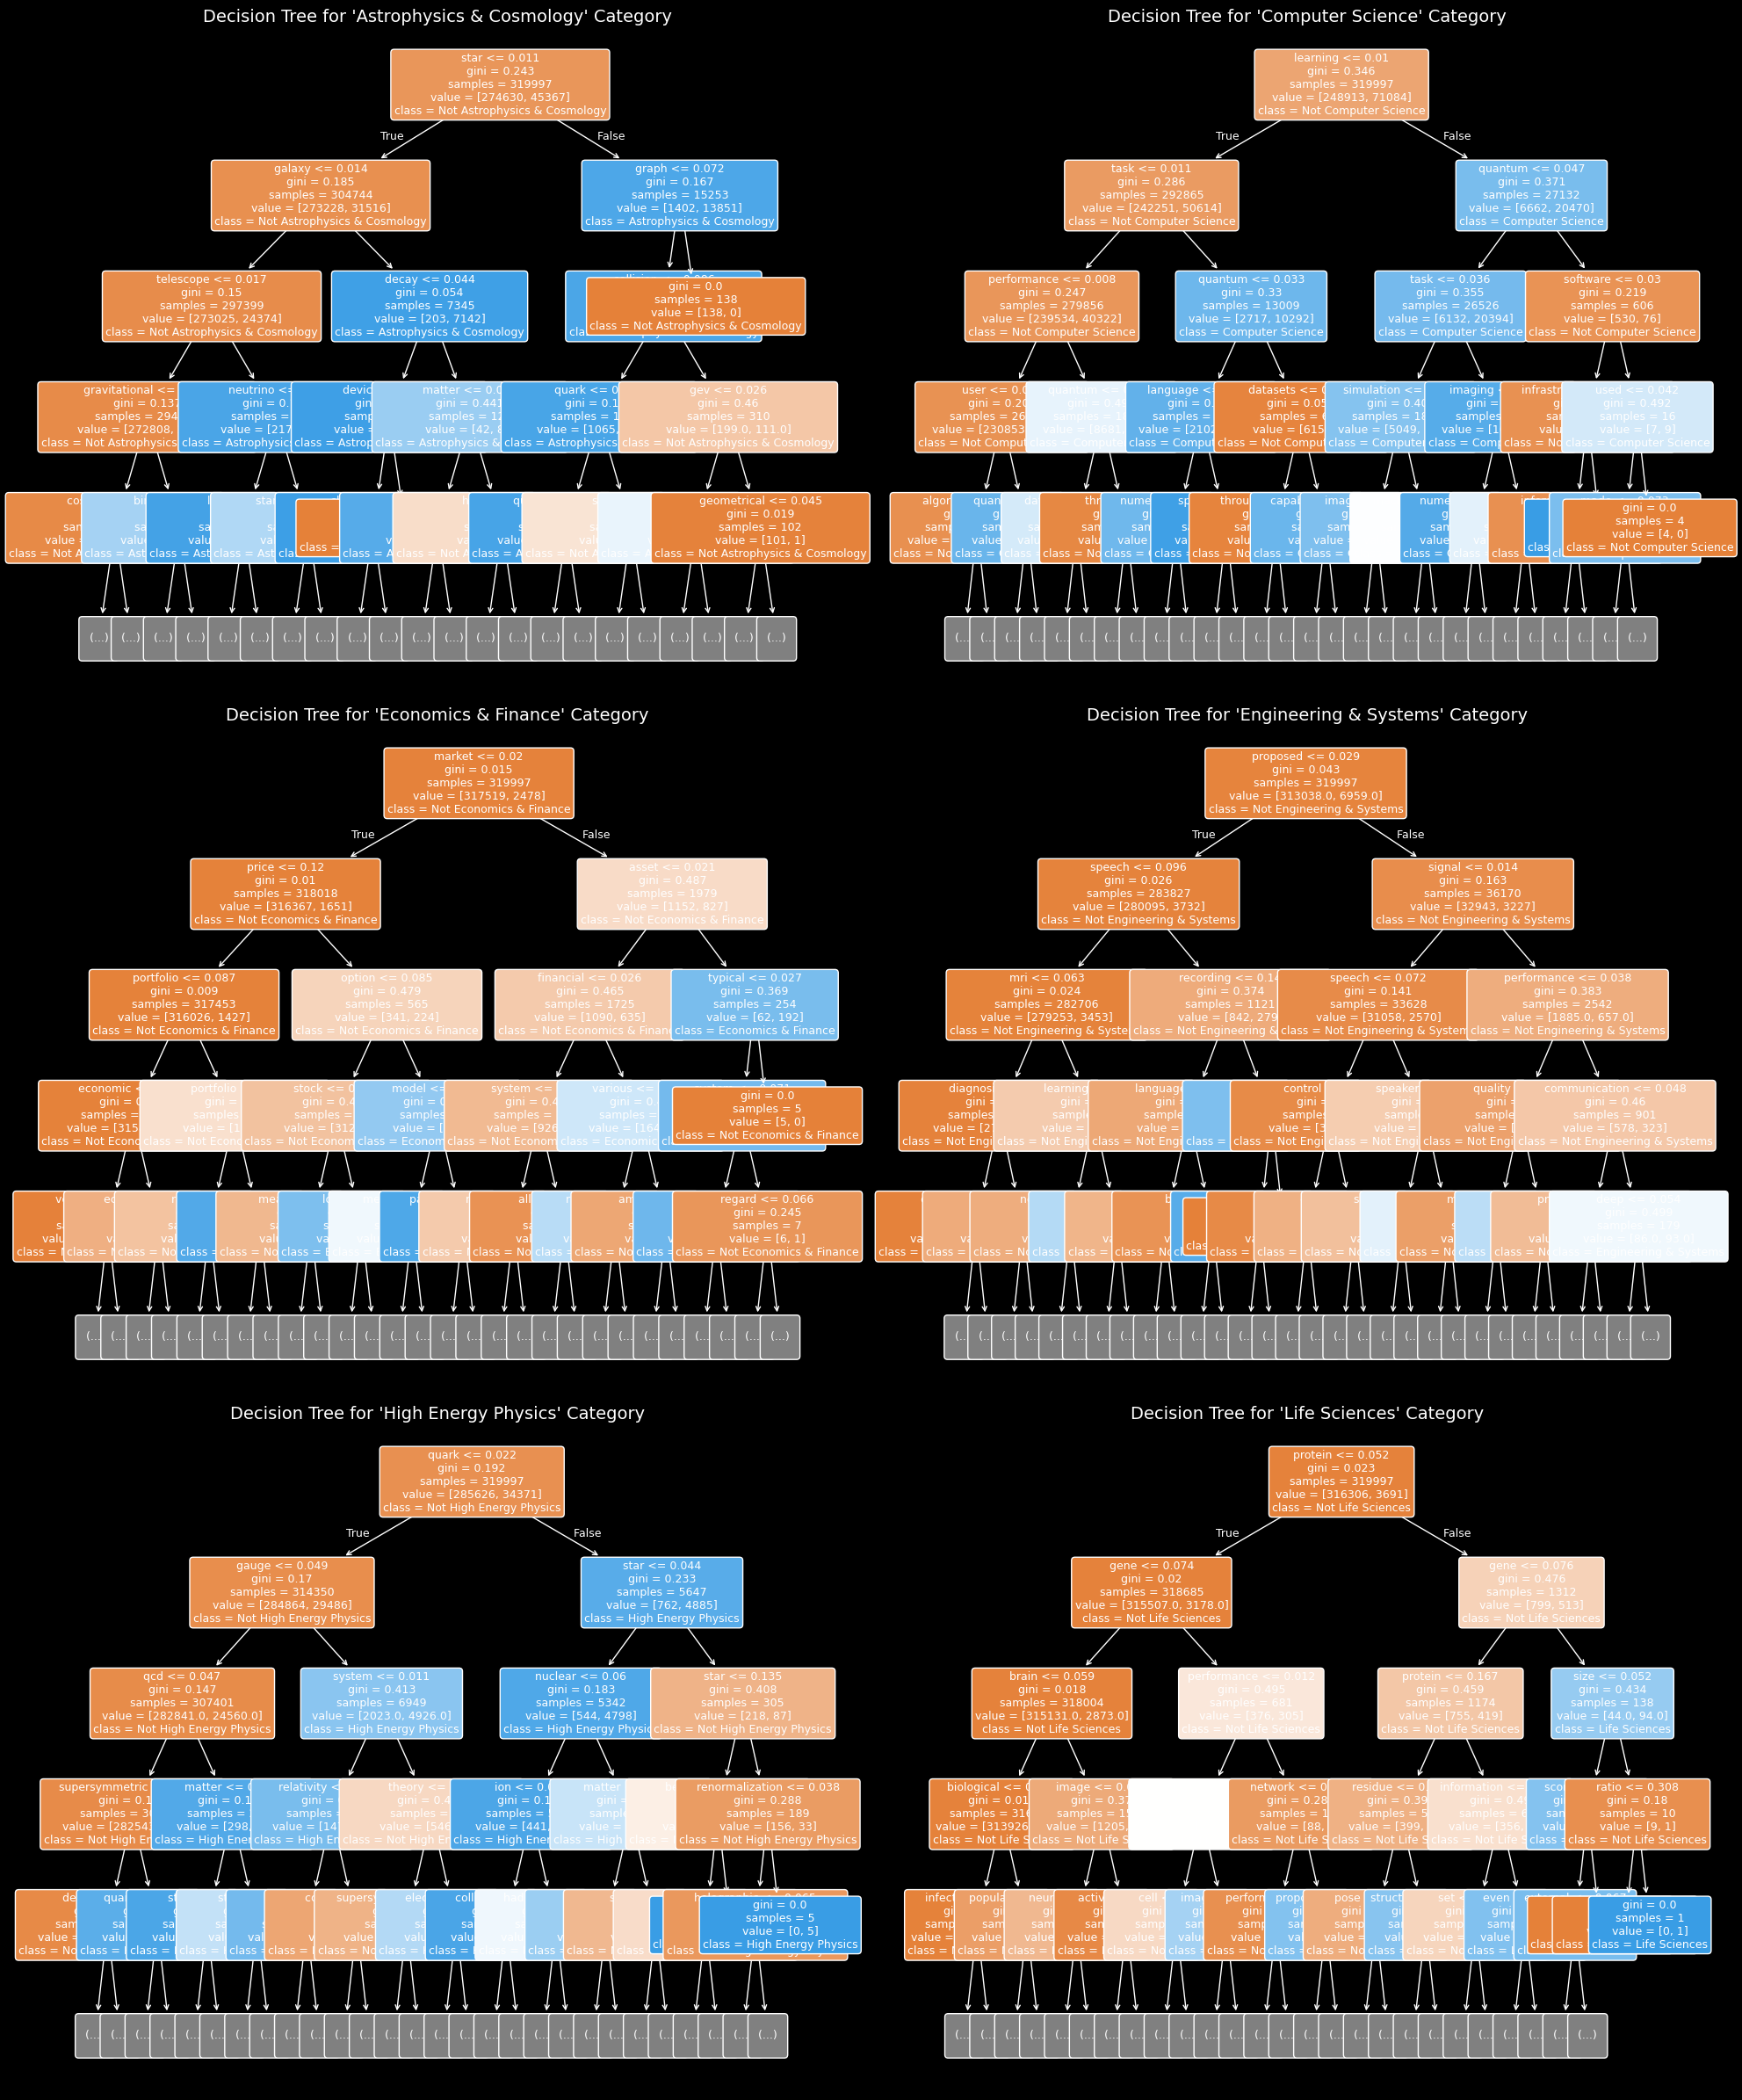

In [7]:
from sklearn import tree

fig, axes = plt.subplots(3, 2, figsize=(20, 24))
axes = axes.flatten()

for i, category in enumerate(categories):
    if i < len(axes):  # Make sure we don't go out of bounds
        # Plot tree on the corresponding subplot
        tree.plot_tree(
            trained_trees[category],
            feature_names=feature_names,
            filled=True,
            rounded=True,
            class_names=["Not " + category, category],
            fontsize=9,
            max_depth=4, # readability
            ax=axes[i]
        )
        axes[i].set_title(f"Decision Tree for '{category}' Category", fontsize=14)

for i in range(len(categories), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# KEYWORD-BASED CLASSIFICATION

In [8]:
def extract_top_keywords(vectorizer, X_train, y_train, n_keywords=15):
    feature_names = vectorizer.get_feature_names_out()
    keywords_dict = {}

    # Group documents by category
    for category in np.unique(y_train):
        # Get indices of documents in this category
        category_indices = np.where(y_train == category)[0]

        if len(category_indices) > 0:
            # Sum TF-IDF values for each word across all documents in this category
            category_tfidf = X_train[category_indices].sum(axis=0)

            # Convert to array and sort by decreasing importance
            category_tfidf = np.asarray(category_tfidf).flatten()
            top_indices = category_tfidf.argsort()[-n_keywords:][::-1]

            # Get the corresponding words
            top_words = [feature_names[i] for i in top_indices]
            keywords_dict[category] = top_words

    return keywords_dict

# 1. For each category (business, entertainment, etc.), we find which words have the highest TF-IDF scores
# 2. We sum TF-IDF values across all documents in each category to identify the most important words
# 3. We select the top N words (20 in this case) for each category
# 4. The result is a dictionary where each category maps to its most distinctive words
keyword_dict = extract_top_keywords(tfidf_vectorizer, X_train_tfidf, y_train, n_keywords=20)
print("Top keywords for each category:")
for category, keywords in keyword_dict.items():
    print(f"{category}: {', '.join(keywords)}")

# Function to predict with keyword matching
def predict_with_keywords(texts, keywords_dict):
    predictions = []

    for text in texts:
        # Count keyword occurrences for each category
        scores = {}
        for category, words in keywords_dict.items():
            score = sum(text.count(word) for word in words)
            scores[category] = score

        # Predict the category with highest keyword count
        if max(scores.values()) > 0:
            predictions.append(max(scores.items(), key=lambda x: x[1])[0])
        else:
            predictions.append("unknown")  # If no keywords match

    return predictions

# 1. For each document in the test set, we count how many times each keyword appears
# 2. For example, if a document contains "film" 3 times, "award" 2 times, and "music" 1 time, the score for "entertainment" would be 6
# 3. We calculate a score for each category by summing the counts of all keywords
# 4. The document is assigned to the category with the highest keyword count
# 5. If no keywords are found, it's labeled as "unknown" (in this case its impossible)
y_pred_method2 = predict_with_keywords(X_test, keyword_dict)
accuracy_method2 = accuracy_score(y_test, y_pred_method2)
print(f"\nMethod 2 Accuracy: {accuracy_method2:.4f}")
print(classification_report(y_test, y_pred_method2))
# It's essentially a simplified version of a Naive Bayes classifier, but using only the most important words rather than the entire vocabulary.

Top keywords for each category:
Astrophysics & Cosmology: star, galaxy, mass, model, observation, emission, field, cluster, source, stellar, spectrum, black, hole, data, energy, line, disk, find, formation, observed
Computer Science: model, network, method, learning, data, algorithm, task, performance, image, problem, approach, system, paper, language, training, propose, proposed, information, graph, feature
Economics & Finance: market, price, model, financial, risk, volatility, stock, portfolio, asset, option, economic, return, pricing, data, time, trading, paper, method, optimal, strategy
Engineering & Systems: image, system, method, proposed, model, network, performance, control, data, signal, learning, algorithm, approach, speech, paper, segmentation, using, result, problem, deep
High Energy Physics: theory, mass, model, decay, gauge, field, quark, neutrino, qcd, symmetry, higgs, string, energy, coupling, result, scalar, state, production, function, particle
Life Sciences: model, c

c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                   precision    recall  f1-score   support

         Astrophysics & Cosmology       0.74      0.60      0.66     11342
                 Computer Science       0.74      0.50      0.60     17771
              Economics & Finance       0.36      0.42      0.39       620
            Engineering & Systems       0.11      0.37      0.16      1740
              High Energy Physics       0.65      0.51      0.58      8593
                    Life Sciences       0.07      0.59      0.12       923
                      Mathematics       0.67      0.68      0.67     15742
                  Nuclear Physics       0.31      0.49      0.38      1340
                          Physics       0.64      0.48      0.55     15910
                  Quantum Physics       0.50      0.48      0.49      3462
Statistics & Mathematical Physics       0.18      0.24      0.20      2557
                          unknown       0.00      0.00      0.00         0

                       

c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
manual_keywords = {
    'Astrophysics_&_Cosmology': ['star', 'galaxy', 'mass','emission', 'observation', 'field',
                                'cluster', 'source', 'stellar', 'black', 'spectrum', 'hole',
                                'energy', 'line', 'disk', 'formation', 'find', 'observed'],

    'Computer_Science': ['network', 'learning', 'method','algorithm', 'task',
                         'performance', 'problem', 'image', 'approach', 'system', 'paper', 'language',
                         'training', 'propose', 'proposed', 'information', 'graph', 'feature'],

    'Economics_&_Finance': ['market', 'price','risk', 'financial', 'volatility', 'stock',
                           'portfolio', 'asset', 'option', 'economic','return', 'trading',
                           'pricing', 'time', 'paper', 'optimal', 'strategy', 'method'],

    'Engineering_&_Systems': ['image', 'system', 'method', 'proposed', 'network', 'performance',
                             'control', 'algorithm', 'signal', 'approach', 'learning', 'speech',
                             'paper', 'segmentation', 'using', 'problem', 'based', 'result'],

    'High_Energy_Physics': ['theory', 'mass', 'decay', 'gauge', 'field', 'quark', 'neutrino',
                           'qcd', 'symmetry', 'higgs', 'string', 'energy', 'coupling', 'result',
                           'production', 'scalar', 'state', 'function', 'boson'],

    'Life_Sciences': ['protein', 'cell', 'network', 'gene', 'population','brain',
                     'dynamic', 'method', 'system', 'specie', 'biological', 'disease', 'study',
                     'analysis', 'neuron', 'time', 'process', 'result'],

    'Mathematics': ['group', 'prove', 'space', 'function', 'problem', 'result', 'equation', 'paper',
                   'algebra', 'solution', 'graph', 'show', 'set', 'number', 'theorem', 'operator',
                   'class', 'give', 'finite', 'condition'],

    'Nuclear_Physics': ['nuclear', 'nucleus', 'energy', 'collision', 'reaction', 'state', 'neutron',
                       'interaction', 'calculation', 'nucleon', 'cross', 'section',
                       'matter', 'scattering', 'momentum', 'density', 'proton', 'result'],

    'Physics': ['state', 'phase', 'system', 'magnetic', 'temperature','field', 'transition',
               'spin', 'quantum', 'energy', 'electron', 'effect', 'interaction', 'structure', 'dynamic',
               'result', 'material', 'show', 'density'],

    'Quantum_Physics': ['quantum', 'state', 'entanglement', 'system', 'measurement', 'classical', 'photon',
                       'qubits', 'protocol', 'gate', 'two', 'show', 'entangled', 'circuit', 'information',
                       'qubit', 'time', 'field', 'phase', 'atom'],

    'Statistics_&_Mathematical_Physics': ['method', 'function', 'equation', 'distribution',
                                         'approach', 'algorithm', 'problem', 'estimator', 'study', 'regression',
                                         'variable', 'proposed', 'bayesian', 'matrix', 'estimation', 'analysis',
                                         'paper', 'operator']
}

# Function to calculate scores for each category
def score_with_manual_keywords(texts, keywords_dict, return_scores=False):
    predictions = []
    all_scores = []

    for text in texts:
        # Calculate score for each category
        scores = {}
        for category, keywords in keywords_dict.items():
            # Convert text to lowercase for case-insensitive matching
            text_lower = text.lower()
            # Count occurrences of each keyword
            score = sum(text_lower.count(word.lower()) for word in keywords)
            scores[category] = score

        # Store all scores if requested
        if return_scores:
            all_scores.append(scores)

        # Predict category with highest score
        if max(scores.values()) > 0:
            predictions.append(max(scores.items(), key=lambda x: x[1])[0])
        else:
            predictions.append("unknown")

    if return_scores:
        return predictions, all_scores
    else:
        return predictions

# Make predictions and get scores
y_pred_manual, all_scores = score_with_manual_keywords(X_test, manual_keywords, return_scores=True)

from sklearn.metrics import accuracy_score, classification_report

accuracy_manual = accuracy_score(y_test, y_pred_manual)
print(f"Manual Keywords Method Accuracy: {accuracy_manual:.4f}")
print(classification_report(y_test, y_pred_manual))

print("\nScore distribution for 5 example documents:")
for i in range(min(5, len(X_test))):
    print(f"\nDocument {i+1} (True category: {y_test.iloc[i]}, Predicted: {y_pred_manual[i]})")
    print(f"Text preview: {X_test.iloc[i][:100]}...")
    print("Category scores:")
    for category, score in sorted(all_scores[i].items(), key=lambda x: x[1], reverse=True):
        print(f"  {category}: {score}")

Manual Keywords Method Accuracy: 0.2382


c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

                                   precision    recall  f1-score   support

         Astrophysics & Cosmology       0.00      0.00      0.00     11342
         Astrophysics_&_Cosmology       0.00      0.00      0.00         0
                 Computer Science       0.00      0.00      0.00     17771
                 Computer_Science       0.00      0.00      0.00         0
              Economics & Finance       0.00      0.00      0.00       620
              Economics_&_Finance       0.00      0.00      0.00         0
            Engineering & Systems       0.00      0.00      0.00      1740
            Engineering_&_Systems       0.00      0.00      0.00         0
              High Energy Physics       0.00      0.00      0.00      8593
              High_Energy_Physics       0.00      0.00      0.00         0
                    Life Sciences       0.00      0.00      0.00       923
                    Life_Sciences       0.00      0.00      0.00         0
                      Ma

c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Weighted Keywords Method Accuracy: 0.1834


c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

                                   precision    recall  f1-score   support

         Astrophysics & Cosmology       0.00      0.00      0.00     11342
         Astrophysics_&_Cosmology       0.00      0.00      0.00         0
                 Computer Science       0.00      0.00      0.00     17771
                 Computer_Science       0.00      0.00      0.00         0
              Economics & Finance       0.00      0.00      0.00       620
              Economics_&_Finance       0.00      0.00      0.00         0
            Engineering & Systems       0.00      0.00      0.00      1740
            Engineering_&_Systems       0.00      0.00      0.00         0
              High Energy Physics       0.00      0.00      0.00      8593
              High_Energy_Physics       0.00      0.00      0.00         0
                    Life Sciences       0.00      0.00      0.00       923
                    Life_Sciences       0.00      0.00      0.00         0
                      Ma

C:\Users\andras.janko\AppData\Local\Temp\ipykernel_29664\2931714.py:223: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([score_data[cat] for cat in categories], labels=categories)


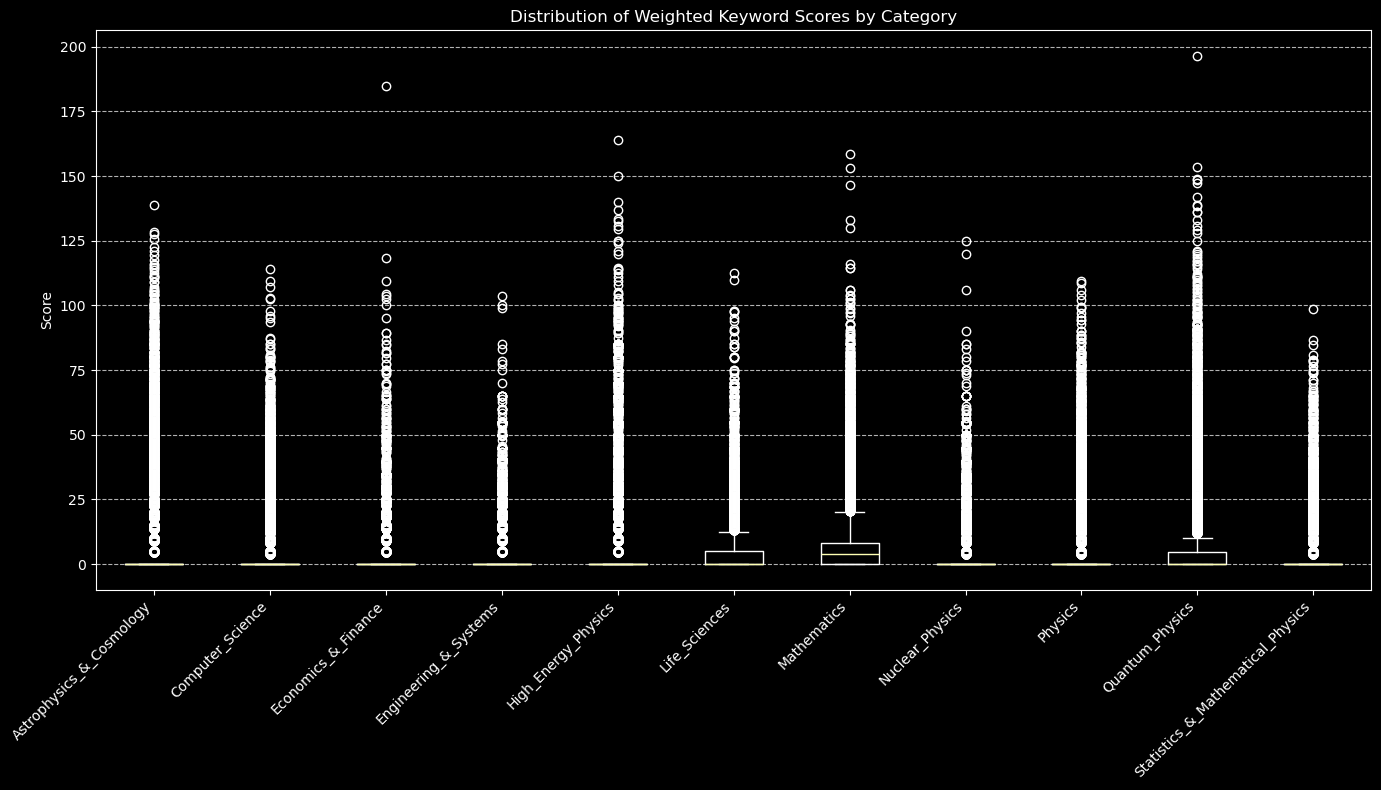

In [10]:
weighted_keywords = {
    'Astrophysics_&_Cosmology': {
        # Retained specific terms from original
        'galaxy': 5.0, 'stellar': 4.5, 'black hole': 5.0, 'disk': 4.5, 'cluster': 4.5,
        # New specific terminology
        'redshift': 5.0, 'supernova': 5.0, 'quasar': 5.0, 'nebula': 4.5,
        'parsec': 5.0, 'pulsar': 5.0, 'dark matter': 5.0, 'dark energy': 5.0,
        'cosmological constant': 5.0, 'gravitational wave': 5.0, 'exoplanet': 5.0,
        'accretion': 4.5, 'magnetohydrodynamics': 5.0, 'cosmic microwave background': 5.0,
        'interstellar medium': 4.5, 'white dwarf': 5.0, 'neutron star': 5.0,
        'active galactic nucleus': 5.0, 'galactic halo': 4.5, 'hubble constant': 5.0
    },

    'Computer_Science': {
        # Retained specific terms from original
        'algorithm': 4.5, 'learning': 4.5, 'language': 4.0, 'training': 4.0,
        # New specific terminology
        'neural network': 5.0, 'transformer model': 5.0, 'backpropagation': 5.0,
        'convolutional': 4.5, 'recurrent neural network': 5.0, 'reinforcement learning': 5.0,
        'deep learning': 5.0, 'natural language processing': 5.0, 'computer vision': 5.0,
        'machine learning': 5.0, 'encoder-decoder': 5.0, 'attention mechanism': 5.0,
        'distributed computing': 4.5, 'parallel processing': 4.5, 'GPU acceleration': 5.0,
        'hyperparameter tuning': 5.0, 'regularization': 4.5, 'overfitting': 4.5,
        'binary classification': 4.5, 'cross-validation': 4.5, 'sentiment analysis': 4.5
    },

    'Economics_&_Finance': {
        # Retained specific terms from original
        'market': 5.0, 'price': 5.0, 'financial': 5.0, 'volatility': 4.5,
        'stock': 5.0, 'portfolio': 4.5, 'asset': 4.5, 'trading': 4.5,
        # New specific terminology
        'yield curve': 5.0, 'arbitrage': 5.0, 'macroeconomics': 5.0, 'microeconomics': 5.0,
        'econometrics': 5.0, 'GDP': 5.0, 'inflation': 5.0, 'derivative': 5.0,
        'futures contract': 5.0, 'hedging': 5.0, 'liquidity': 4.5, 'quantitative easing': 5.0,
        'fiscal policy': 5.0, 'monetary policy': 5.0, 'interest rate': 4.5,
        'forex': 5.0, 'diversification': 4.5, 'blue chip': 4.5, 'central bank': 5.0,
        'exchange-traded fund': 5.0, 'equity premium': 5.0, 'dividend yield': 4.5
    },

    'Engineering_&_Systems': {
        # Retained specific terms from original
        'control': 5.0, 'signal': 5.0, 'speech': 4.5, 'segmentation': 4.5,
        # New specific terminology
        'bandwidth': 4.5, 'impedance': 5.0, 'transistor': 5.0, 'modulation': 5.0,
        'amplifier': 4.5, 'filter design': 5.0, 'servo mechanism': 5.0, 'PID controller': 5.0,
        'FPGA': 5.0, 'microcontroller': 5.0, 'embedded system': 5.0, 'actuator': 4.5,
        'sensor array': 4.5, 'resonance frequency': 5.0, 'feedback loop': 5.0,
        'transfer function': 5.0, 'mechatronics': 5.0, 'robotics': 4.5,
        'analog circuit': 5.0, 'digital signal processing': 5.0, 'nyquist criterion': 5.0
    },

    'High_Energy_Physics': {
        # Retained specific terms from original
        'decay': 5.0, 'gauge': 5.0, 'quark': 5.0, 'neutrino': 5.0, 'qcd': 5.0,
        'higgs': 5.0, 'coupling': 4.5, 'scalar': 4.5, 'boson': 5.0,
        # New specific terminology
        'hadron': 5.0, 'lepton': 5.0, 'gluon': 5.0, 'fermion': 5.0,
        'supersymmetry': 5.0, 'standard model': 5.0, 'quantum chromodynamics': 5.0,
        'renormalization': 5.0, 'lattice gauge theory': 5.0, 'parton': 5.0,
        'electron-positron annihilation': 5.0, 'hadron collider': 5.0,
        'feynman diagram': 5.0, 'electroweak interaction': 5.0, 'flavor oscillation': 5.0,
        'top quark': 5.0, 'charm quark': 5.0, 'strange quark': 5.0, 'kaon': 5.0
    },

    'Life_Sciences': {
        # Retained specific terms from original
        'protein': 5.0, 'cell': 5.0, 'gene': 5.0, 'population': 4.0,
        'brain': 4.5, 'specie': 4.5, 'biological': 4.5, 'disease': 4.5, 'neuron': 4.5,
        # New specific terminology
        'genome': 5.0, 'transcription factor': 5.0, 'translation': 4.5, 'phenotype': 5.0,
        'genotype': 5.0, 'apoptosis': 5.0, 'mitochondria': 5.0, 'ribosome': 5.0,
        'amino acid': 5.0, 'nucleotide': 5.0, 'enzyme kinetics': 5.0, 'metabolism': 4.5,
        'lipid bilayer': 5.0, 'epithelial tissue': 5.0, 'cytokine': 5.0,
        'receptor binding': 5.0, 'signaling pathway': 5.0, 'immunoglobulin': 5.0,
        'synaptic plasticity': 5.0, 'neurodegeneration': 5.0, 'CRISPR': 5.0
    },

    'Mathematics': {
        # Retained specific terms from original
        'prove': 5.0, 'group': 4.5, 'algebra': 5.0, 'set': 4.0, 'theorem': 5.0,
        'operator': 4.0, 'finite': 4.0,
        # New specific terminology
        'topology': 5.0, 'manifold': 5.0, 'homology': 5.0, 'cohomology': 5.0,
        'isomorphism': 5.0, 'homomorphism': 5.0, 'Lie group': 5.0, 'Banach space': 5.0,
        'Hilbert space': 5.0, 'eigenvalue decomposition': 5.0, 'tensor product': 5.0,
        'differential geometry': 5.0, 'stochastic process': 5.0, 'measure theory': 5.0,
        'partial differential equation': 5.0, 'Fourier transform': 5.0,
        'Galois theory': 5.0, 'category theory': 5.0, 'commutative ring': 5.0,
        'algebraic topology': 5.0, 'manifold learning': 5.0
    },

    'Nuclear_Physics': {
        # Retained specific terms from original
        'nuclear': 5.0, 'nucleus': 5.0, 'neutron': 5.0, 'cross section': 4.5,
        'nucleon': 5.0, 'scattering': 4.0, 'proton': 5.0,
        # New specific terminology
        'fission': 5.0, 'fusion': 5.0, 'isotope': 5.0, 'radioactivity': 5.0,
        'half-life': 5.0, 'beta decay': 5.0, 'alpha particle': 5.0,
        'deuterium': 5.0, 'tritium': 5.0, 'tokamak': 5.0, 'stellarator': 5.0,
        'nuclide': 5.0, 'enrichment': 4.5, 'chain reaction': 5.0, 'moderator': 5.0,
        'containment vessel': 5.0, 'heavy water': 5.0, 'plutonium': 5.0,
        'gamma radiation': 5.0, 'nuclear magnetic moment': 5.0, 'nuclear shell model': 5.0
    },

    'Physics': {
        # Retained specific terms from original
        'phase transition': 5.0, 'magnetic': 4.5, 'temperature': 4.0,
        'spin': 4.5, 'electron': 4.5, 'material': 4.5,
        # New specific terminology
        'superconductivity': 5.0, 'ferromagnetism': 5.0, 'paramagnetism': 5.0,
        'diamagnetism': 5.0, 'bose-einstein condensate': 5.0, 'josephson junction': 5.0,
        'critical temperature': 5.0, 'hysteresis': 5.0, 'phonon': 5.0,
        'brillouin zone': 5.0, 'anisotropy': 5.0, 'crystallography': 5.0,
        'lattice vibration': 5.0, 'perovskite': 5.0, 'semiconductor': 5.0,
        'band gap': 5.0, 'hall effect': 5.0, 'piezoelectric': 5.0,
        'thermoelectric': 5.0, 'magneto-optic': 5.0, 'ferroelectric': 5.0
    },

    'Quantum_Physics': {
        # Retained specific terms from original
        'quantum': 5.0, 'entanglement': 5.0, 'measurement': 4.0, 'classical': 4.0,
        'photon': 5.0, 'qubits': 5.0, 'protocol': 4.0, 'gate': 4.5, 'entangled': 5.0,
        'circuit': 4.0, 'qubit': 5.0, 'atom': 4.0,
        # New specific terminology
        'superposition': 5.0, 'decoherence': 5.0, 'wavefunction collapse': 5.0,
        'schrödinger equation': 5.0, 'heisenberg uncertainty': 5.0, 'bell inequality': 5.0,
        'quantum teleportation': 5.0, 'quantum cryptography': 5.0, 'quantum supremacy': 5.0,
        'quantum dot': 5.0, 'interferometer': 5.0, 'quantum tunneling': 5.0,
        'qutrit': 5.0, 'density matrix': 5.0, 'hamiltonian': 5.0,
        'eigenstate': 5.0, 'quantum field theory': 5.0, 'quantum error correction': 5.0,
        'quantum annealing': 5.0, 'quantum advantage': 5.0
    },

    'Statistics_&_Mathematical_Physics': {
        # Retained specific terms from original
        'distribution': 5.0, 'estimator': 5.0, 'regression': 5.0, 'variable': 4.0,
        'bayesian': 5.0, 'matrix': 4.0, 'estimation': 4.5,
        # New specific terminology
        'p-value': 5.0, 'confidence interval': 5.0, 'null hypothesis': 5.0,
        'ANOVA': 5.0, 'multivariate analysis': 5.0, 'correlation coefficient': 5.0,
        'covariance matrix': 5.0, 'monte carlo simulation': 5.0, 'markov chain': 5.0,
        'maximum likelihood estimation': 5.0, 'posterior distribution': 5.0,
        'prior distribution': 5.0, 'hierarchical model': 5.0, 'time series analysis': 5.0,
        'factor analysis': 5.0, 'principal component analysis': 5.0,
        'kernel density estimation': 5.0, 'regularization parameter': 5.0,
        'statistical significance': 5.0, 'statistical power': 5.0
    }
}

# Function to calculate weighted scores for each category
def score_with_weighted_keywords(texts, weighted_keywords, return_scores=False):
    predictions = []
    all_scores = []

    for text in texts:
        # Calculate weighted score for each category
        scores = {}
        text_lower = text.lower()  # Convert to lowercase for case-insensitive matching

        for category, word_weights in weighted_keywords.items():
            # Sum of (word count * weight) for each keyword
            score = sum(text_lower.count(word.lower()) * weight
                        for word, weight in word_weights.items())
            scores[category] = score

        # Store all scores if requested
        if return_scores:
            all_scores.append(scores)

        # Predict category with highest score
        if max(scores.values()) > 0:
            predictions.append(max(scores.items(), key=lambda x: x[1])[0])
        else:
            predictions.append("unknown")

    if return_scores:
        return predictions, all_scores
    else:
        return predictions

# Make predictions and get scores
y_pred_weighted, all_weighted_scores = score_with_weighted_keywords(X_test, weighted_keywords, return_scores=True)

from sklearn.metrics import accuracy_score, classification_report

accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
print(f"Weighted Keywords Method Accuracy: {accuracy_weighted:.4f}")
print(classification_report(y_test, y_pred_weighted))

print("\nWeighted score distribution for 5 example documents:")
for i in range(min(5, len(X_test))):
    print(f"\nDocument {i+1} (True category: {y_test.iloc[i]}, Predicted: {y_pred_weighted[i]})")
    print(f"Text preview: {X_test.iloc[i][:100]}...")
    print("Category scores:")
    for category, score in sorted(all_weighted_scores[i].items(), key=lambda x: x[1], reverse=True):
        print(f"  {category}: {score:.2f}")

# Visualize the weighted scores for misclassified examples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred_weighted)) if true != pred]

if misclassified_indices:
    print(f"\nAnalyzing {min(5, len(misclassified_indices))} misclassified examples:")
    for idx in misclassified_indices[:5]:  # Look at up to 5 misclassified examples
        print(f"\nMisclassified Document (True: {y_test.iloc[idx]}, Predicted: {y_pred_weighted[idx]})")
        print(f"Text preview: {X_test.iloc[idx][:150]}...")
        print("Category scores:")
        for category, score in sorted(all_weighted_scores[idx].items(), key=lambda x: x[1], reverse=True):
            print(f"  {category}: {score:.2f}")
        print("-" * 50)

try:
    import matplotlib.pyplot as plt

    # Plot the distribution of scores across categories
    plt.figure(figsize=(14, 8))
    categories = list(weighted_keywords.keys())

    score_data = {cat: [] for cat in categories}
    for i in range(len(y_test)):
        for category in categories:
            score_data[category].append(all_weighted_scores[i][category])

    plt.boxplot([score_data[cat] for cat in categories], labels=categories)
    plt.title('Distribution of Weighted Keyword Scores by Category')
    plt.ylabel('Score')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("Matplotlib not available for visualization")

# CONDITIONAL FREQUENCY DISTRIBUTION

In [ ]:
# 1. The function builds a Counter object (instead of ConditionalFreqDist), which tracks how frequently each word appears in each category
# 2. For each document in our training set, it efficiently counts word occurrences by category using collections.Counter
# 3. After counting all words, it identifies words that are strongly associated with specific categories
# 4. It pre-computes total word counts across all categories to avoid redundant calculations
# 5. Words are considered "distinctive" if: They appear at least min_count times in a category (default 10)
#    AND at least distinctiveness proportion of their occurrences (default 70%) are in that category
# 6. The result is a dictionary where each category is mapped to words that are strongly associated with it
# 7. These words are automatically discovered from the data, rather than manually defined
# 8. The function then uses these automatically discovered keywords with the same prediction method as KEYWORD-BASED CLASSIFICATION
# 9. This optimized version uses built-in Python data structures for better performance and avoids unnecessary NLTK dependencies
def build_cfd_model_optimized(texts, categories, min_count=10, distinctiveness=0.7):
    # Use collections.Counter for faster word counting
    from collections import Counter, defaultdict

    # Create a dictionary to store word counts per category
    category_word_counts = defaultdict(Counter)

    # Pre-compute unique categories (only once)
    unique_categories = set(categories)

    # Count word frequencies by category
    for text, category in zip(texts, categories):
        # Use set to count each word only once per document (if needed)
        # Or keep Counter for term frequency if that's required
        words = [word for word in text.split() if len(word) > 2]
        category_word_counts[category].update(words)

    # Find distinctive words more efficiently
    category_keywords = {}

    # Precompute total counts for each word across all categories
    total_word_counts = Counter()
    for category_counts in category_word_counts.values():
        total_word_counts.update(category_counts)

    # Find distinctive words for each category
    for category in unique_categories:
        distinctive_words = []

        # Only examine words that appear in this category with sufficient frequency
        for word, count in category_word_counts[category].items():
            if count > min_count:
                # We already know the word appears enough times in this category
                # Now check if it appears distinctively in this category
                if (count / total_word_counts[word]) > distinctiveness:
                    distinctive_words.append(word)

        category_keywords[category] = distinctive_words

    return category_keywords

# Build the CFD model
cfd_keywords = build_cfd_model_optimized(X_train, y_train)

print("CFD-derived keywords for each category:")
for category, keywords in cfd_keywords.items():
    print(f"{category}: {', '.join(keywords[:20])}")

y_pred_method3 = predict_with_keywords(X_test, cfd_keywords)
accuracy_method3 = accuracy_score(y_test, y_pred_method3)
print(f"\nMethod 3 Accuracy: {accuracy_method3:.4f}")
print(classification_report(y_test, y_pred_method3))

CFD-derived keywords for each category:
Computer Science: wireless, popularity, mobile, networking, researcher, cognitive, interactive, management, marketing, language, llm, pose, harmful, user, guardrail, threat, safety, policy, deployment, conduct
Nuclear Physics: cranked, sly4, pionless, tbf, hypernuclei, 12c, amev, qmd, buu, ampt, isgmr, nl3, isotones, phenix, 40ca, 197au, fissioning, multifragmentation, qrpa, 6he
Physics: superconductor, edelstein, phonons, gennes, zeeman, quasiparticle, nonreciprocal, superconducting, glass, gaas, grown, epitaxy, diffraction, cathodoluminescence, photoluminescence, strain, dislocation, material, fabrication, nanowires
Statistics & Mathematical Physics: breiman, estimands, knockoff, spca, estimand, ipw, emos, glmm, cpms, inla, ignorability, changepoints, changepoint, intercurrent, placebo, transportability, nonresponse, tmle, overdispersed, glmms
Astrophysics & Cosmology: companion, star, supernova, ejecta, stellar, luminosity, constrain, burst, s

c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

                                   precision    recall  f1-score   support

         Astrophysics & Cosmology       0.45      0.78      0.57     11342
                 Computer Science       0.37      0.94      0.53     17771
              Economics & Finance       0.00      0.00      0.00       620
            Engineering & Systems       0.00      0.00      0.00      1740
              High Energy Physics       0.92      0.05      0.09      8593
                    Life Sciences       0.00      0.00      0.00       923
                      Mathematics       0.88      0.15      0.25     15742
                  Nuclear Physics       0.00      0.00      0.00      1340
                          Physics       0.59      0.45      0.51     15910
                  Quantum Physics       0.00      0.00      0.00      3462
Statistics & Mathematical Physics       0.00      0.00      0.00      2557
                          unknown       0.00      0.00      0.00         0

                       

c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Summary

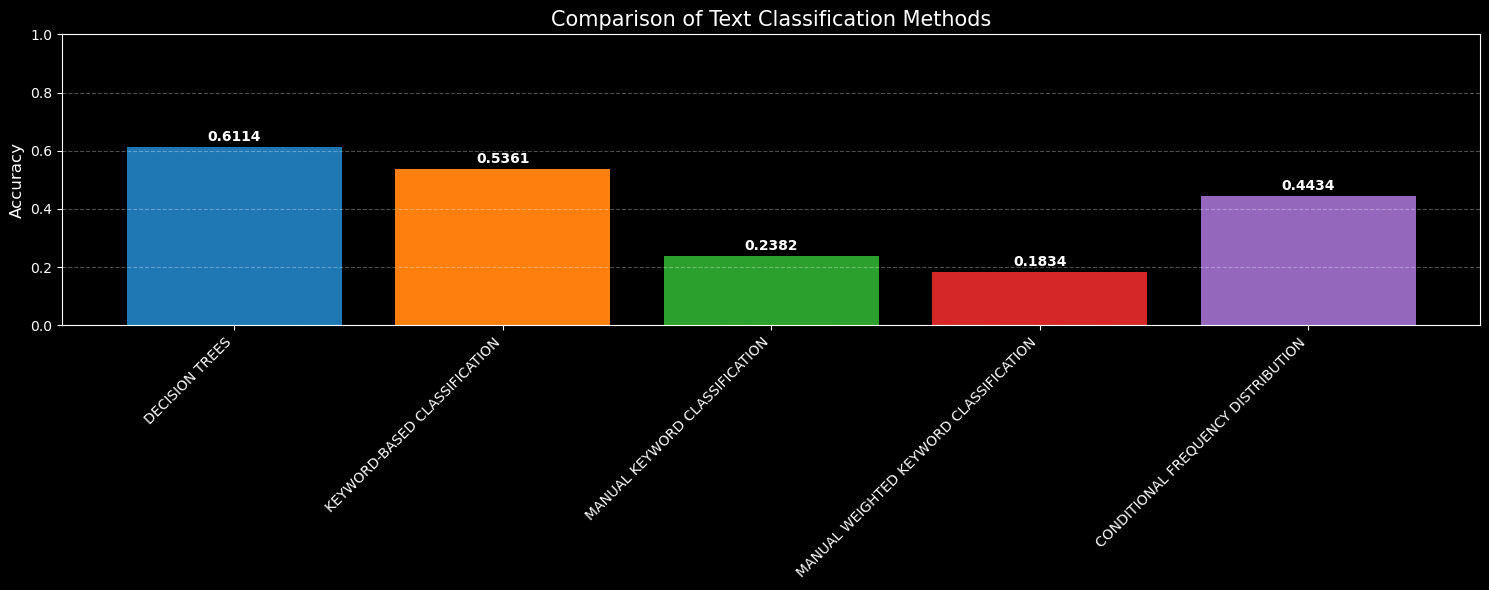

C:\Users\andras.janko\AppData\Local\Temp\ipykernel_29664\4054199688.py:37: RuntimeWarning: invalid value encountered in divide
  class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)
C:\Users\andras.janko\AppData\Local\Temp\ipykernel_29664\4054199688.py:37: RuntimeWarning: invalid value encountered in divide
  class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)
C:\Users\andras.janko\AppData\Local\Temp\ipykernel_29664\4054199688.py:37: RuntimeWarning: invalid value encountered in divide
  class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)
C:\Users\andras.janko\AppData\Local\Temp\ipykernel_29664\4054199688.py:37: RuntimeWarning: invalid value encountered in divide
  class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)


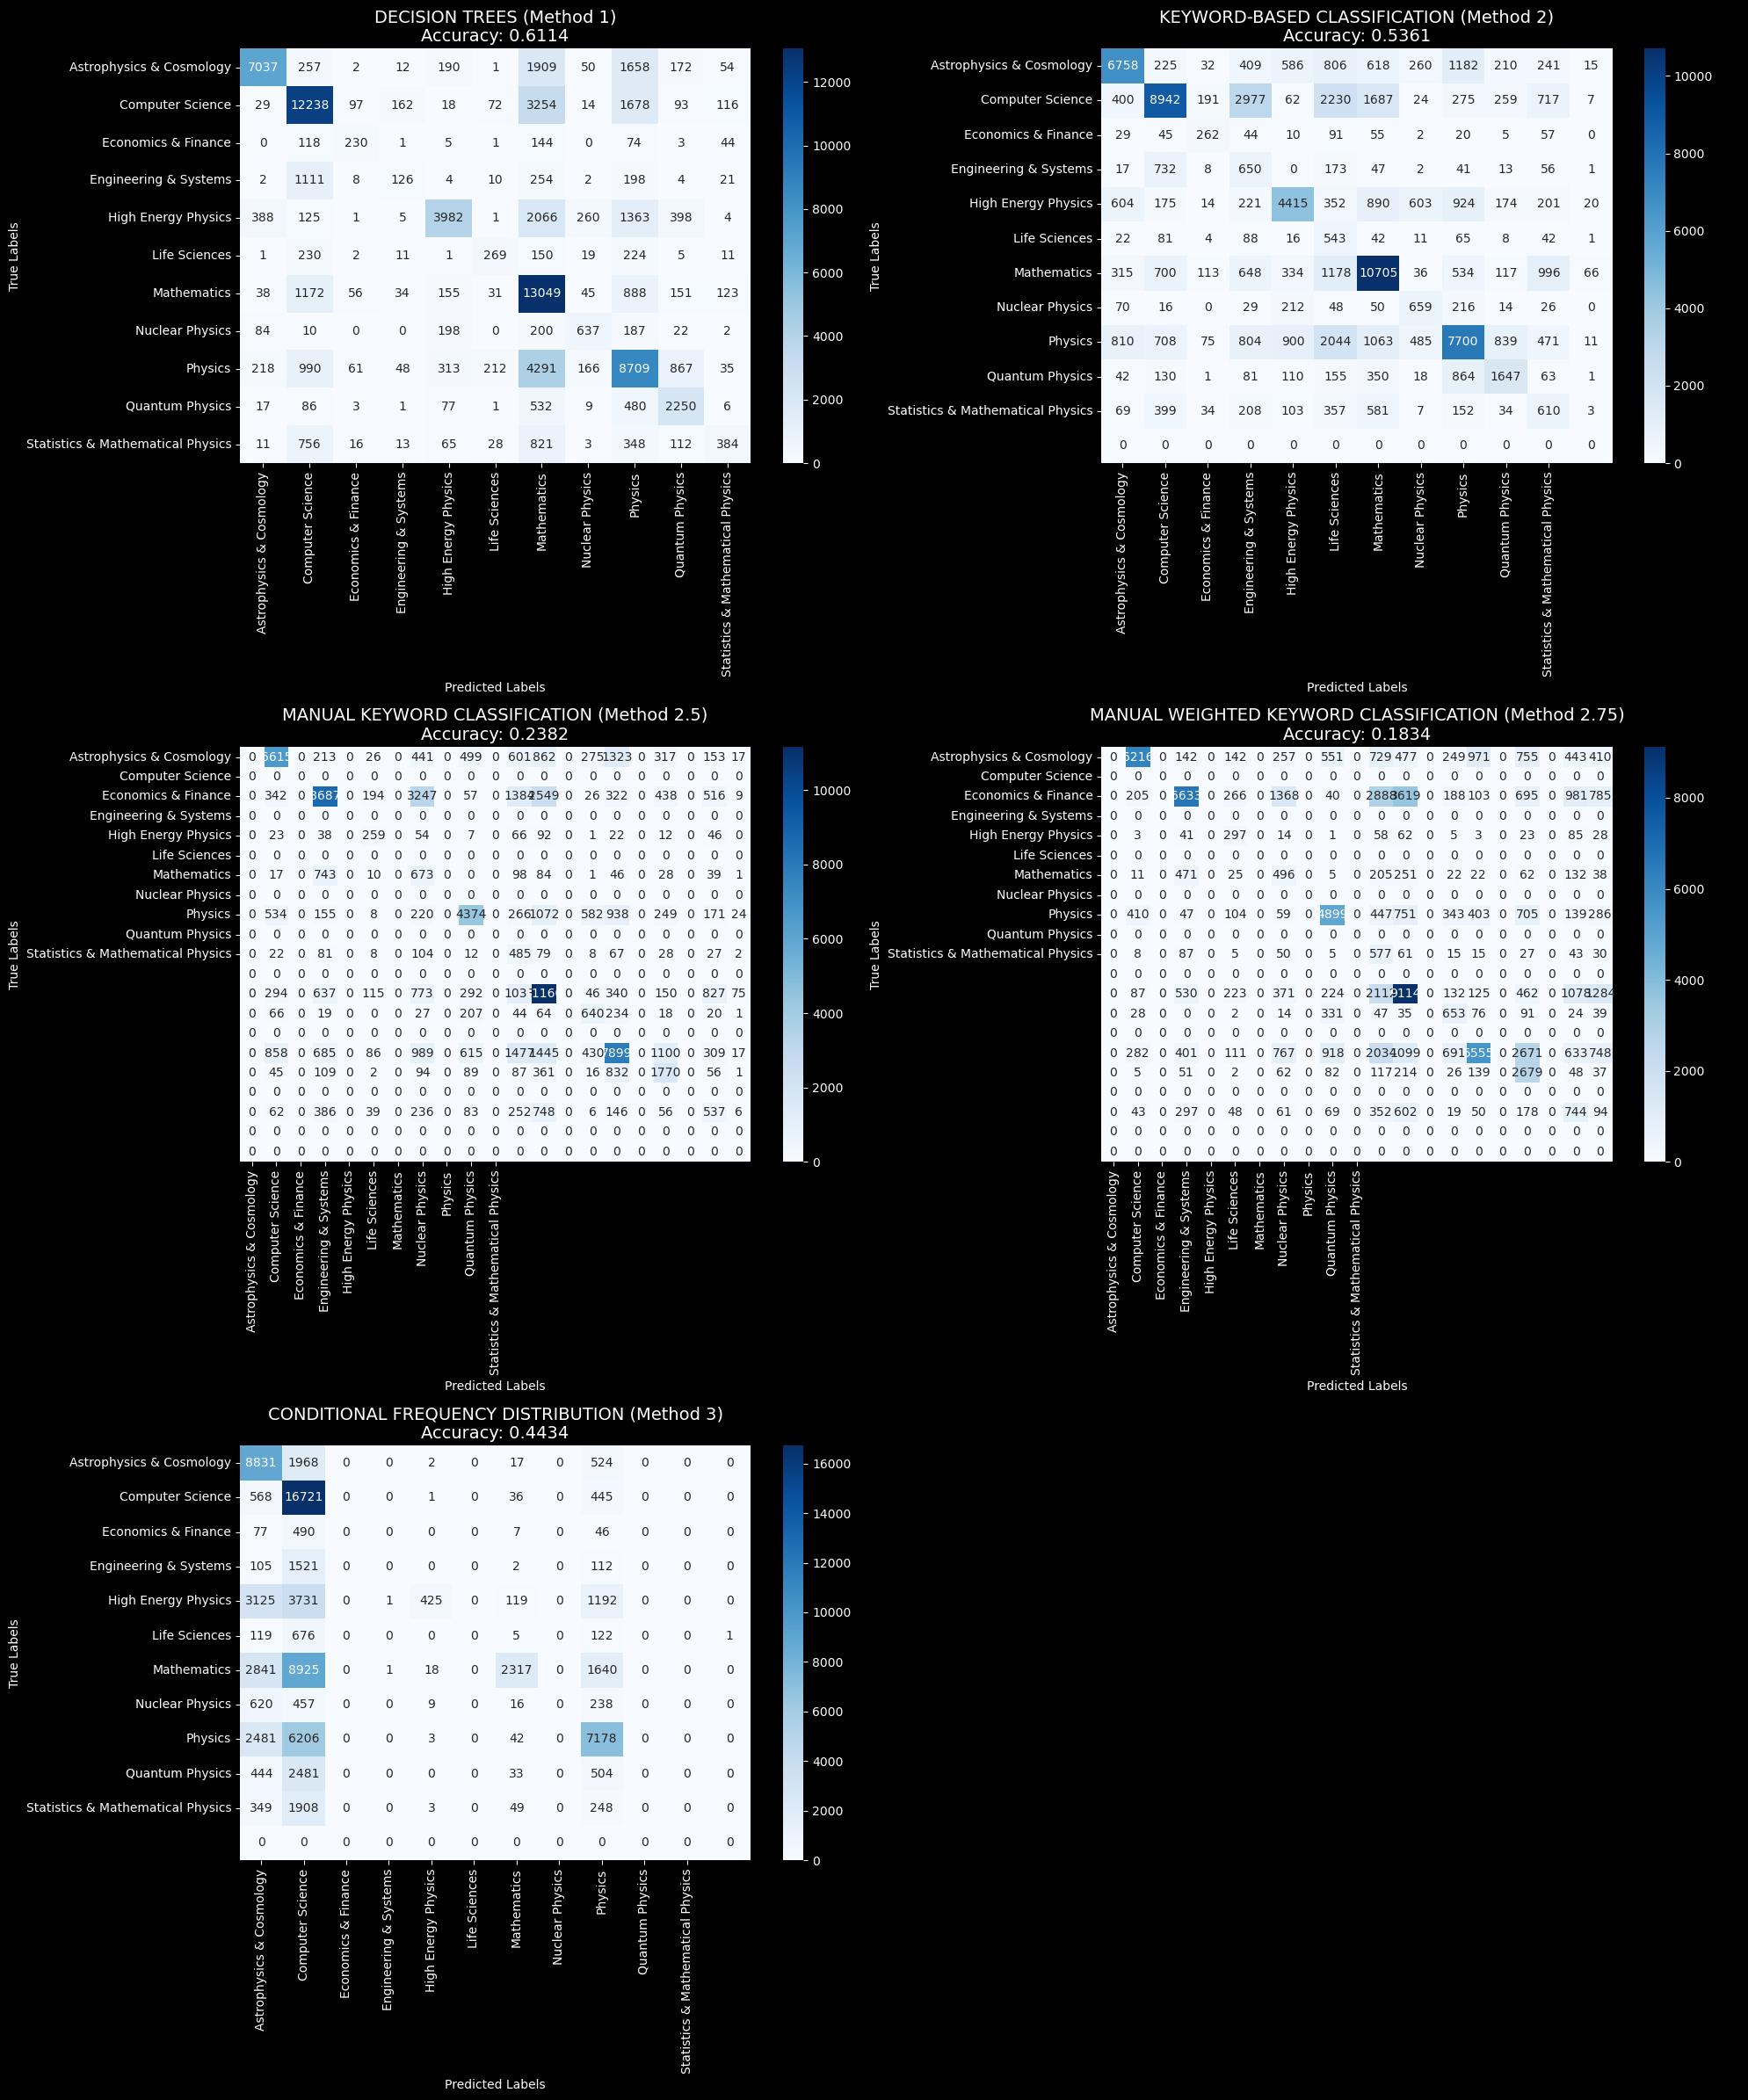

c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

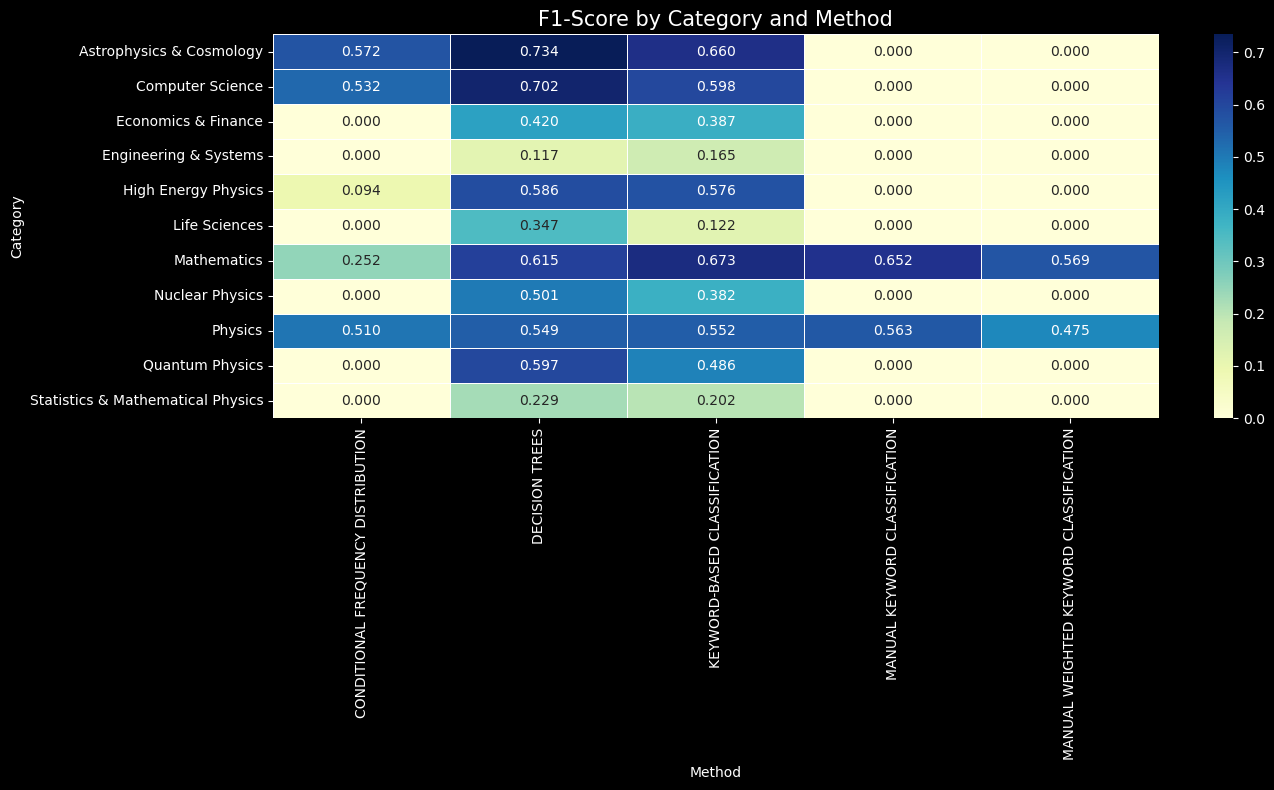

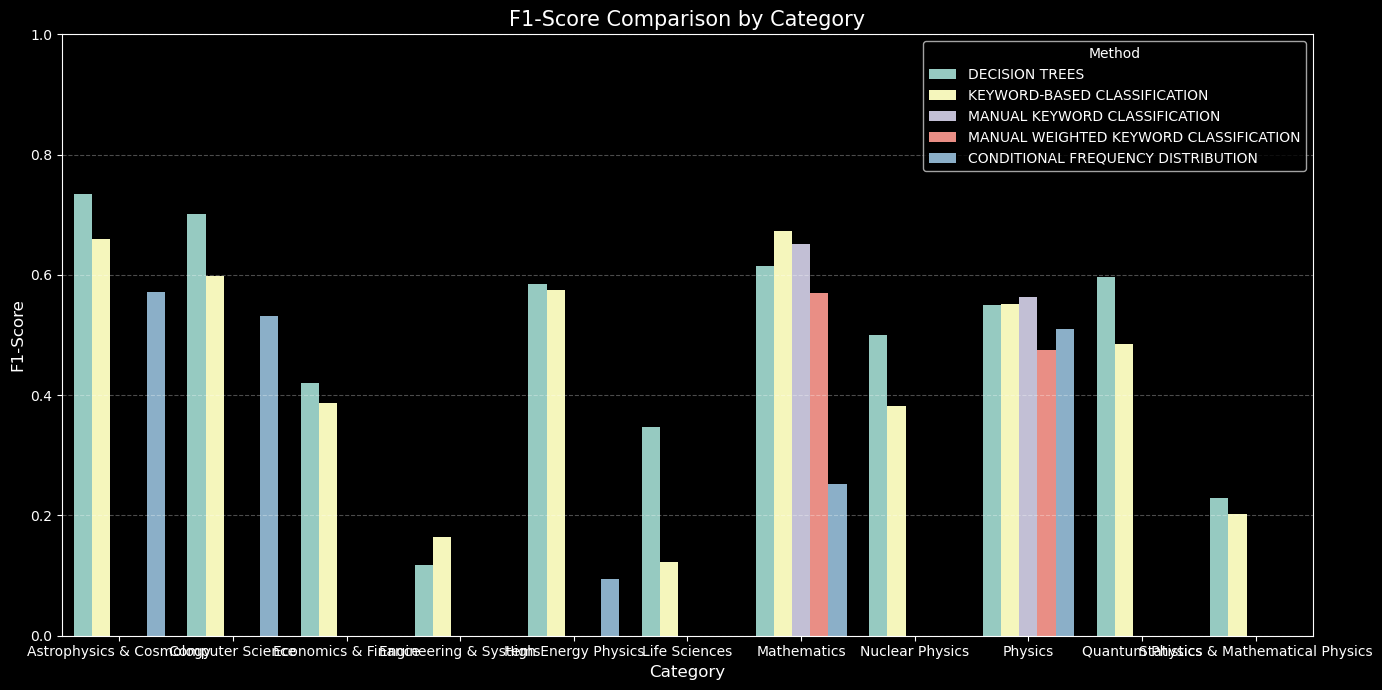

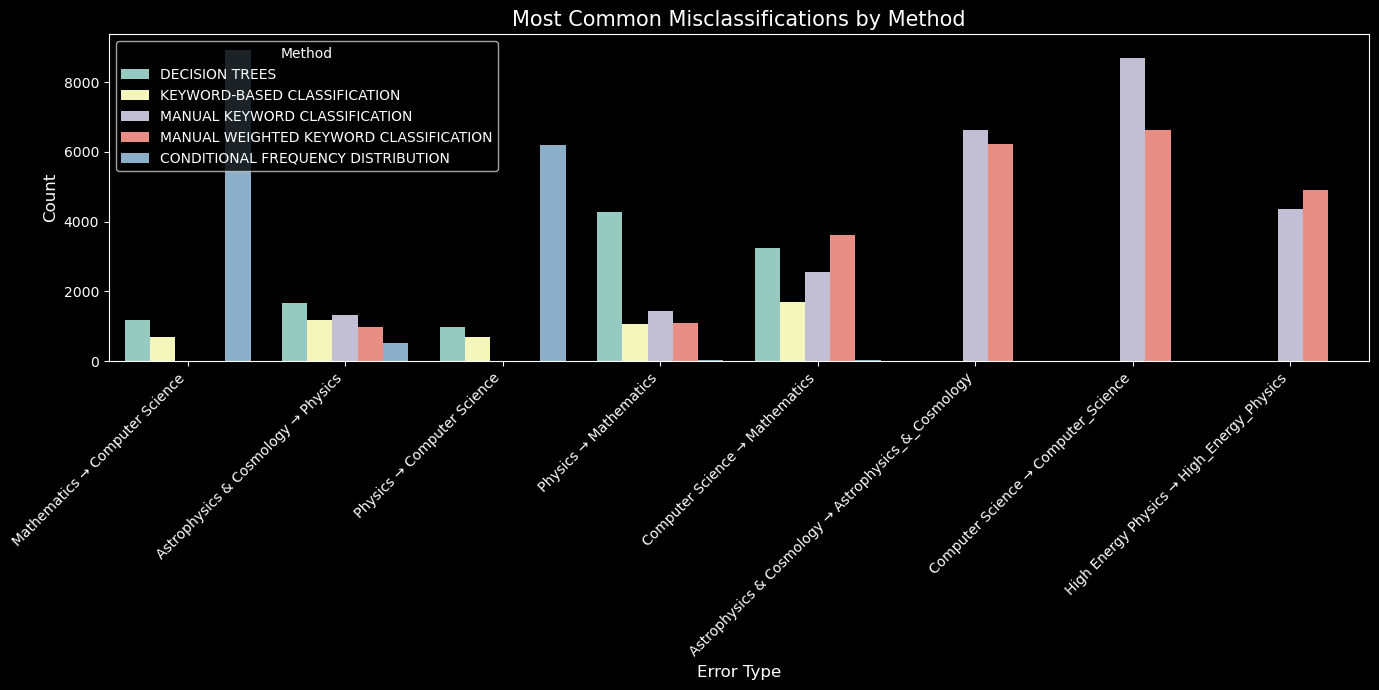

c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap


=== METHOD COMPARISON ===

                                Method  Accuracy  Macro Avg F1  Weighted Avg F1  Macro Avg Precision  Macro Avg Recall
                        DECISION TREES    0.6114        0.4906           0.6046               0.5663            0.4690
          KEYWORD-BASED CLASSIFICATION    0.5361        0.4002           0.5722               0.4127            0.4473
         MANUAL KEYWORD CLASSIFICATION    0.2382        0.0578           0.2401               0.0596            0.0574
MANUAL WEIGHTED KEYWORD CLASSIFICATION    0.1834        0.0497           0.2065               0.0621            0.0442
    CONDITIONAL FREQUENCY DISTRIBUTION    0.4434        0.1633           0.3603               0.2672            0.1973

=== CATEGORY ANALYSIS ===

F1-Scores by Category:
Method                             CONDITIONAL FREQUENCY DISTRIBUTION  \
Category                                                                
Astrophysics & Cosmology                                     

c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
methods = ["DECISION TREES", "KEYWORD-BASED CLASSIFICATION", "MANUAL KEYWORD CLASSIFICATION", "MANUAL WEIGHTED KEYWORD CLASSIFICATION", "CONDITIONAL FREQUENCY DISTRIBUTION"]
method_names = {"DECISION TREES": "Method 1",
                "KEYWORD-BASED CLASSIFICATION": "Method 2",
                "MANUAL KEYWORD CLASSIFICATION": "Method 2.5",
                "MANUAL WEIGHTED KEYWORD CLASSIFICATION": "Method 2.75",
                "CONDITIONAL FREQUENCY DISTRIBUTION": "Method 3"}

predictions = [y_pred_method1_tfidf, y_pred_method2, y_pred_manual, y_pred_weighted, y_pred_method3]
accuracies = [accuracy_method1_tfidf, accuracy_method2, accuracy_manual, accuracy_weighted, accuracy_method3]

# 1. Accuracy comparison bar chart
plt.figure(figsize=(15, 6))
bars = plt.bar(methods, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Text Classification Methods', fontsize=15)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(rotation=45, ha='right')

# Add accuracy labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.01, f"{acc:.4f}",
             ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Confusion matrices for all methods
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
axes = axes.flatten()
categories = sorted(df[category_column].unique())

for i, (method, preds) in enumerate(zip(methods, predictions)):
    if i < len(axes):  # Make sure we don't exceed bounds
        conf_mat = confusion_matrix(y_test, preds)

        # Calculate accuracy per class
        class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)

        # Plot confusion matrix
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                    xticklabels=categories, yticklabels=categories, ax=axes[i])
        axes[i].set_title(f'{method} ({method_names[method]})\nAccuracy: {accuracies[i]:.4f}', fontsize=14)
        axes[i].set_xlabel('Predicted Labels')
        axes[i].set_ylabel('True Labels')

# Hide the unused subplot
if len(methods) < len(axes):
    for idx in range(len(methods), len(axes)):
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

# 3. Per-category performance across methods
categories = sorted(df[category_column].unique())
category_metrics = []

for method_idx, (method, preds) in enumerate(zip(methods, predictions)):
    # Get classification report as dict
    report = classification_report(y_test, preds, output_dict=True)

    # Extract metrics for each category
    for category in categories:
        if category in report:
            precision = report[category]['precision']
            recall = report[category]['recall']
            f1 = report[category]['f1-score']
            support = report[category]['support']

            category_metrics.append({
                'Method': method,
                'Category': category,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'Support': support
            })

metrics_df = pd.DataFrame(category_metrics)

# Plot F1-scores by category
plt.figure(figsize=(14, 8))
pivot_table = metrics_df.pivot(index='Category', columns='Method', values='F1-Score')
ax = sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.3f', linewidths=0.5)
plt.title('F1-Score by Category and Method', fontsize=15)
plt.tight_layout()
plt.show()

# 4. Identification of most challenging categories
plt.figure(figsize=(14, 7))
sns.barplot(x='Category', y='F1-Score', hue='Method', data=metrics_df)
plt.title('F1-Score Comparison by Category', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.ylim(0, 1.0)
plt.legend(title='Method')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Error analysis - finding common misclassifications
misclassification_counts = {}

for method_idx, (method, preds) in enumerate(zip(methods, predictions)):
    # Find misclassifications
    misclassified = [(true, pred) for true, pred in zip(y_test, preds) if true != pred]

    # Count by error type
    for true, pred in misclassified:
        key = f"{true} → {pred}"
        if key not in misclassification_counts:
            # Create a list with one entry for each method (5 methods)
            misclassification_counts[key] = [0, 0, 0, 0, 0]
        misclassification_counts[key][method_idx] += 1

# Convert to DataFrame and plot
error_data = []
for error_type, counts in misclassification_counts.items():
    for method_idx, count in enumerate(counts):
        error_data.append({
            'Error Type': error_type,
            'Method': methods[method_idx],
            'Count': count
        })

error_df = pd.DataFrame(error_data)

# Filter to show only the most common misclassifications
top_errors = error_df.groupby('Error Type')['Count'].sum().nlargest(8).index

plt.figure(figsize=(14, 7))
sns.barplot(x='Error Type', y='Count', hue='Method',
            data=error_df[error_df['Error Type'].isin(top_errors)])
plt.title('Most Common Misclassifications by Method', fontsize=15)
plt.xlabel('Error Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Method')
plt.tight_layout()
plt.show()

# 6. Summary table of all metrics
summary_data = []
for method_idx, (method, preds) in enumerate(zip(methods, predictions)):
    report = classification_report(y_test, preds, output_dict=True)

    summary_data.append({
        'Method': method,
        'Accuracy': accuracies[method_idx],
        'Macro Avg F1': report['macro avg']['f1-score'],
        'Weighted Avg F1': report['weighted avg']['f1-score'],
        'Macro Avg Precision': report['macro avg']['precision'],
        'Macro Avg Recall': report['macro avg']['recall']
    })

summary_df = pd.DataFrame(summary_data)

print("\n=== METHOD COMPARISON ===\n")
print(summary_df.round(4).to_string(index=False))

print("\n=== CATEGORY ANALYSIS ===\n")
pivot_f1 = metrics_df.pivot(index='Category', columns='Method', values='F1-Score')
print("F1-Scores by Category:")
print(pivot_f1.round(4))

# 7. Find the best method for each category
best_method_by_category = pivot_f1.idxmax(axis=1)
print("\nBest Method for Each Category:")
for category, best_method in best_method_by_category.items():
    best_f1 = pivot_f1.loc[category, best_method]
    print(f"{category}: {best_method} (F1={best_f1:.4f})")